# Monte Carlo methods

> *SG2227/FSG3130 Uncertainty Analysis<br />
 KTH Engineering Mechanics <br />
 Saleh Rezaeiravesh and Philipp Schlatter (November 2022)*

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from scipy import special
from scipy import stats
from scipy.stats import norm,uniform,binom

π=mt.pi

## Simple Monte Carlo method: Compute π

The standard example of a Monte Carlo method: Compute $\pi$ by randomly drawing samples for two uniform distributions between $-1$ and $+1$ and checking whether or not these points are inside a circle with radius $1$. The total area of the square is 4, and the area occupied by the circle is $\pi$. Therefore, the fraction of points inside corresponds then to $\pi/4$.

This method is related to the *rejection sampling method*, which we will not consider further here. 

<IPython.core.display.Javascript object>


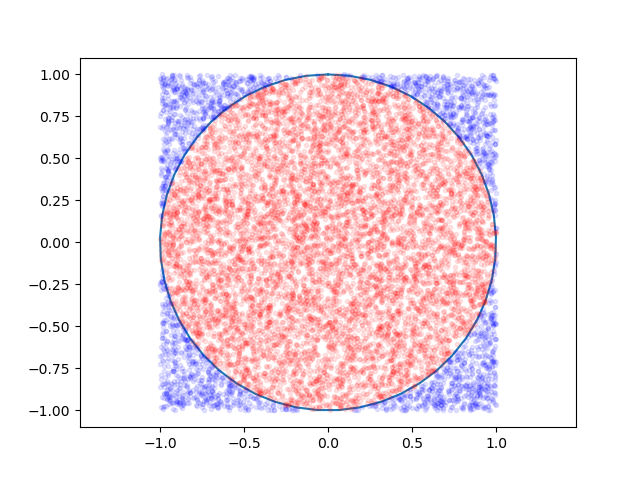

Estimate of π with 10000 samples is: 3.098000


In [2]:
N = 10000
x = (np.random.random_sample(N)-0.5)*2
y = (np.random.random_sample(N)-0.5)*2
count = 0
xin = []; yin=[];
xout = []; yout=[];
for i in range(N):
    if ((x[i]**2+y[i]**2)<1):
        count = count + 1    
        xin.append(x[i])
        yin.append(y[i])
    else:
        xout.append(x[i])
        yout.append(y[i])
        

plt.figure()
# plt.plot(x[:1000],y[:1000],'.')
t=np.linspace(0,100)
plt.plot(np.sin(t*2*π/100),np.cos(t*2*π/100))
plt.axis('equal')
plt.plot(xin,yin,'r.',alpha=0.1)
plt.plot(xout,yout,'b.',alpha=0.1)
plt.show()
        
print('Estimate of π with %i samples is: %.6f' % (N,(count/N)*4))  

<IPython.core.display.Javascript object>


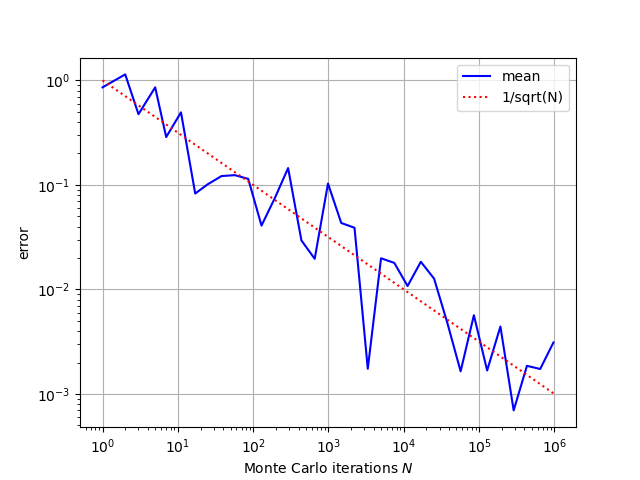

In [3]:
# check convergence of a simple Monte Carlo method

Ne = 34
cc = np.zeros(Ne)
mm = np.zeros(Ne)
for j in range(Ne):
    N = int(1.5**(j+1))
    cc[j] = N
    x = (np.random.random_sample(N)-0.5)*2
    y = (np.random.random_sample(N)-0.5)*2
    
    count = 0
    for i in range(N):
        if ((x[i]**2+y[i]**2)<1):
            count = count + 1    
    mm[j] = np.abs(count/N*4-π)
    
plt.figure()
plt.loglog(cc,mm,'b',label='mean')
plt.loglog(cc,1/np.sqrt(cc),'r:',label='1/sqrt(N)')
plt.grid('on')
plt.xlabel('Monte Carlo iterations $N$');plt.ylabel('error')
plt.legend()
plt.show()


The convergence of a Monte Carlo method is typically quite slow, in this case as usual proportional to the square root $\sqrt{N}$ of the number of iterations $N$.

## Example: Nonlinear error propagation

Consider the model $y = 5 \sqrt{x}$ where the error propagation from $x$ to $y$ should be studied. Linearisation (the Taylor series method) gives a relative uncertainty 
$$\frac{u_y}{y} = \frac{1}{2}\frac{u_x}{x} \ ,$$
and an absolute uncertainty
$$u_y = \frac{5}{2\sqrt{x}} u_x \ .$$

We take $x=1$ and measure $y=5$. Assuming an uncertainty in $x$ of $u_x/x=1\%$ gives us the corresponding uncertainty in $y$ as $u_y/u=0.5\%$, or in absolute numbers $u_y=0.025$. 


<IPython.core.display.Javascript object>


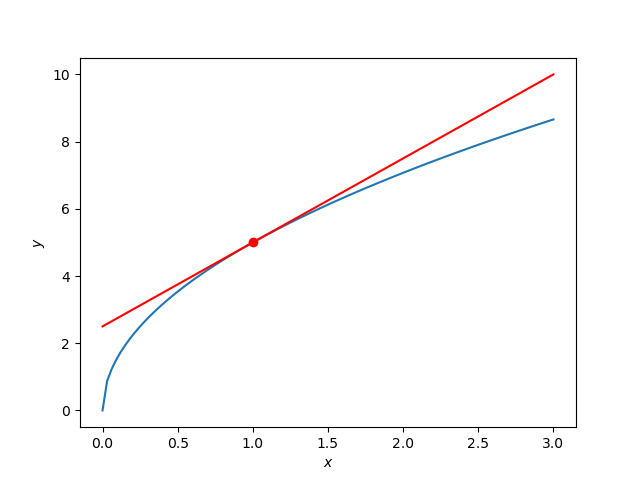

In [4]:
x = np.linspace(0,3,100)
y = lambda x: 5*np.sqrt(np.abs(x))

plt.figure()
plt.plot()
plt.plot(x,y(x))
plt.plot(1,y(1),'ro')
plt.plot(x,5+5/2*(x-1),'r')
plt.xlabel('$x$');plt.ylabel('$y$')
plt.show()

For the Monte Carlo method we assume that the uncertainty is Gaussian with zero mean and variance $u_x^2$. So we sample $\tilde{y} = 5 \tilde{x}^{1/2}$ with $\tilde{x}=1+\mathcal{N}(0,u_x^2)$.

In the below example, setting the relative uncertainty of $x$ to $1\%$, we get relative uncertainty (standard deviation divided by the mean) of $y$ to $0.5\%$, exactly as with the linearised method. Setting the uncertainty of $x$ to $40\%$, we see that the arisind distribution is no longer normal, and the uncertainty has risen to $22\%$. Note also that the mean of the distribution (the expected value) has gone down to $4.88$.

<IPython.core.display.Javascript object>


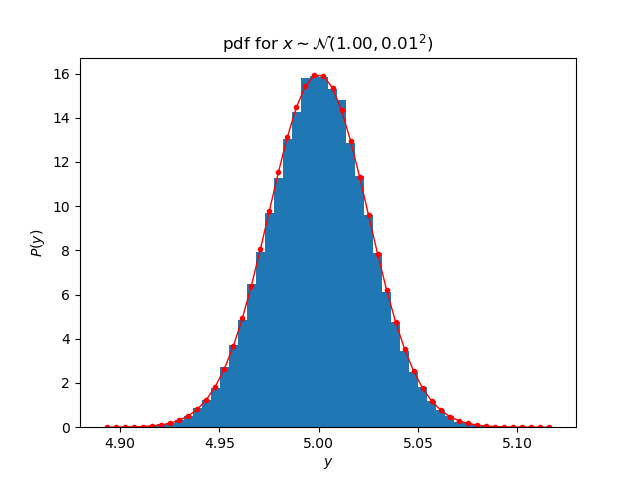

(4.999909575602422, 0.004993861672968438)

In [10]:
N=100000
x = 1
x_rel = 0.01
#x_rel = 0.4
ux = x_rel*x
# Sample from the normal distribution
xtilde = np.random.normal(x,ux,N)
ytilde = y(xtilde)
nbins = 50  # number of bins
plt.figure()
count, bins, ignored = plt.hist(ytilde, nbins, density=True)
bc = (bins[0:-1]+bins[1:])/2   # bin centres
plt.plot(bc, norm.pdf(bc,np.mean(ytilde),np.std(ytilde)), '.-',linewidth=1, color='r')
plt.xlabel('$y$')
plt.ylabel('$P(y)$')
plt.title('pdf for $x\sim\mathcal{N}(%.2f, %.2f^2)$'%(x,x_rel))
np.mean(ytilde),np.std(ytilde)/np.mean(ytilde)

### Hands-on:

Plot the model equation $y(x)$ with error bars indicating the 95% confidence intervals for different uncertainties in $x$.

---
---
---
---
---
---
---

## Markov-Chain Monte-Carlo Method (MCMC)

As in the above example, for the Monte Carlo method to work, we need to sample from a given distribution; in the previous case is was the one-dimensional normal distribution. However, in practice there are situations where one needs to sample from more complicated distributions (e.g. with multiple peaks), and in multiple dimensions (e.g. when one has multiple input variables with each their own distribution). In those cases, finding the right joint distribution is not easy, and taking samples from it is even more difficult. In particular, the proper normalisation factors may be missing (i.e. the integral is not unity), which makes an inverse sampling method impractical.

Therefore, there are alternative methods commonly use in Monte Carlo method. The perhaps easiest one is the rejection sampling method, going back to von Neumann. A variant of that we have used in the case of computing $\pi$. Whereas this method works well in one dimension, it suffers from the *curse of dimensionality* as more and more samples need to be rejected. 

One popular alternative is based on a Markov chain, i.e. a memory-less process that predicts the outcome solely on the present state, akin a random walk. Here we try to the *Metropolis-Hastings algorithm* to sample from a function `sampling_dist` which does not need to include a normalisation factor in principle.

The principle is straightforward: We select a new point $x'$, compute the probability in that point $P(x')$ compared to the current point $P(x)$, and move in the direction of higher probability. If the probability is lower, we reject the move if the acceptance ratio,
$$R = \mathrm{min}\left(1, \frac{P(x')}{P(x)}  \right) $$
is below a uniform random number between zero and one. The method needs a few steps in the beginning (burn in), and one typically also uses a lag (i.e. one does not use every sample since the method may stagnate at times).

In this example, we sample from the normal distribution, and recover, as expected, the normal distribution. However, we could now use the sampled points to evaluate for instance integrals of the form
$$\int P(x) A(x) \mathrm dx$$
where $P(x)$ is the sampled distribution, and $A(x)$ any other function (equalling to unity in the example here).

<IPython.core.display.Javascript object>


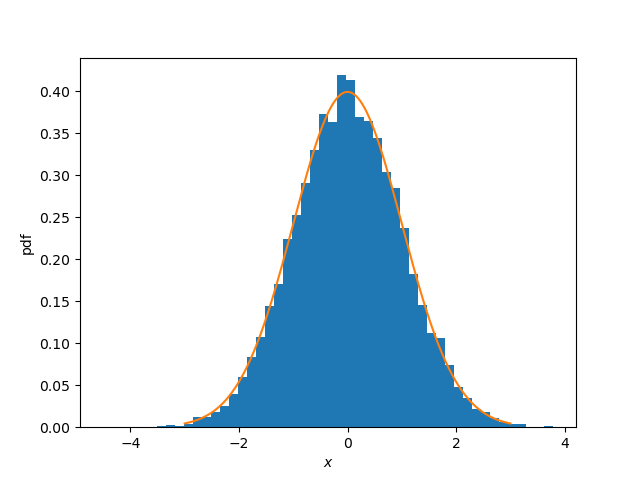

DescribeResult(nobs=16000, minmax=(-4.512412895203686, 3.792486232245633), mean=0.008973218423369442, variance=0.9983430379202812, skewness=0.013626029144766127, kurtosis=0.03352340890735572)

In [61]:
def sampling_dist(x,mu,sigma):
    numerator = np.exp((-(x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def random_coin(p):
    unif = np.random.random_sample()
    if unif>=p:
        return False
    else:
        return True
    
# Metropolis-Hastings algorithm    
def mcmc_MH(hops,lag,mu,sigma):
    states = np.zeros(hops)
    burn_in = int(hops*0.2)
    current = (np.random.random_sample()-0.5)*2*5*sigma+mu
    for i in range(hops):
        states[i] = current
        movement = (np.random.random_sample()-0.5)*2*5*sigma+mu
        
        curr_prob = sampling_dist(x=current,mu=mu,sigma=sigma)
        move_prob = sampling_dist(x=movement,mu=mu,sigma=sigma)
        
        acceptance = min(move_prob/curr_prob,1)
        if random_coin(acceptance):
            current = movement
    return states[burn_in:-1:lag]

dist = mcmc_MH(100000,5,mu=0,sigma=1)    
plt.figure()
nbins = 50
count, bins, ignored = plt.hist(dist, nbins, density=True) 

lines = np.linspace(-3,3,1000)
normal_curve = [sampling_dist(l,mu=0,sigma=1) for l in lines]
plt.plot(lines,normal_curve)
plt.xlabel('$x$');plt.ylabel('pdf')
plt.show()

stats.describe(dist)

Now the same thing, but in a Bayes setting. This example is taken from https://towardsdatascience.com/bayesian-inference-and-markov-chain-monte-carlo-sampling-in-python-bada1beabca7. 

The Bayes theorem is
$$ P(H|E) = \frac{P(E|H) \cdot P(H)}{P(E)} $$
with the prior $P(H)$ (the probablility of our hypothesis without data), the likelihood $P(E|H)$ and the marginal likelihood $P(E)$.

In our setting, we consider a coin-toss experiment (probability $p$ to be heads) where $n=100$ experiments have been performed with outcome of $x=57$ heads. So our Bayesian description becomes
$$P(p|x) \sim P(x|p) P(p) \ .$$

Essentially, one wants to sample $P(p|x)$, knowing $P(x|p)$ (the likelihood, i.e. distribution of how many heads for given coin probability, which is the binomial distribution), and $P(p)$ (the prior distribution of $p$ without data, taken as uniform as we do not know better). The acceptance ratio is 
$$R=\mathrm{min}\left(1, \frac{ P(x|p')}{P(x|p)} \frac{P(p')}{P(p)}  \right) $$
where we also added the prior, which however does not matter since it is a uniform distribution.

Running this example will sample the binomial distribution with $x$ and $n$. We can read off the most likely value for $p$, which is very close to the expected value from the frequency $x/n$. This is expected since our prior was uniform, i.e. we did not have any information.

In [84]:
# Define the data
x = 57
n = 100

# Define the Likelihood P(x|p) - binomial distribution
def likelihood(p):
    return stats.binom.pmf(x, n, p)

# Define Prior Function - Uniform Distribution
def prior(p):
    return stats.uniform.pdf(p)

# Create function to compute acceptance ratio R
def acceptance_ratio(p, p_new):
    # Return R, using the functions we created before
    return min(1, ((likelihood(p_new) / likelihood(p)) * (prior(p_new) / prior(p))))

In [85]:
# Create empty list to store samples
results = []

# Initialzie a value of p
p = np.random.uniform(0, 1)    # same as np.random.random_sample()

# Define model parameters
n_samples = 100000
burn_in = 5000
lag = 1

# Create the MCMC loop
for i in range(n_samples):
    # Propose a new value p' of p randomly from a uniform distribution between 0 and 1
    p_new = np.random.random_sample()
    # Compute acceptance probability
    R = acceptance_ratio(p, p_new)
    # Draw random sample to compare R to
    u = np.random.random_sample()
    # If R is greater than u, accept the new value of p (set p = p_new)
    if u < R:
        p = p_new
    # Record values after burn in - how often determined by lag
    if i > burn_in and i%lag == 0:
        results.append(p)

<IPython.core.display.Javascript object>


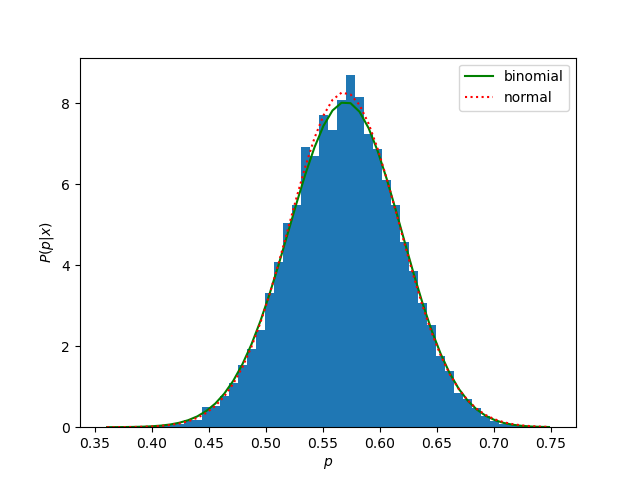

0.5688449371906975

In [86]:
plt.figure()
nbins = 50
count, bins, ignored = plt.hist(results, nbins, density=True)
bc = (bins[0:-1]+bins[1:])/2   # bin centres
plt.plot(bc,stats.binom.pmf(x,n,bc)*n,'g',label='binomial')
plt.plot(bc,stats.norm.pdf(bc,np.mean(results),np.std(results)),'r:',label='normal')
plt.ylabel('$P(p|x)$')
plt.xlabel('$p$')
plt.legend()
plt.show()
np.mean(results)